## Classification

### Basic Setup

In [3]:
import sys

assert sys.version_info >= (3,7) # require python version>= 3.7

In [4]:
from packaging import version

import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1") # need sklearn version >= 1.0.1

In [7]:
import matplotlib.pyplot as plt

# define the define font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [23]:
# also define a funtion which will use to save images

from pathlib import Path

IMAGE_PATH = Path() / "images" / "classification"
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

def save_image(fig_id, tigh_layout=True, extension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{extension}"
    if tigh_layout:
        plt.tight_layout()
    plt.savefig(path, format=extension, dpi=resolution)

### MNIST

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # we set as_Frame=False because opneml generally return input as DateFrame but MNIST datasets contain IMages so DateFrame is notnot ideal for images

In [13]:
X, y = mnist.data, mnist.target

In [16]:
X, X.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784)),
 (70000, 784))

In [17]:
y, y.shape

(array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object),
 (70000,))

In [18]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [19]:
# Each image size of 28*28 pixel and that's why each image has 784 features

In [20]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

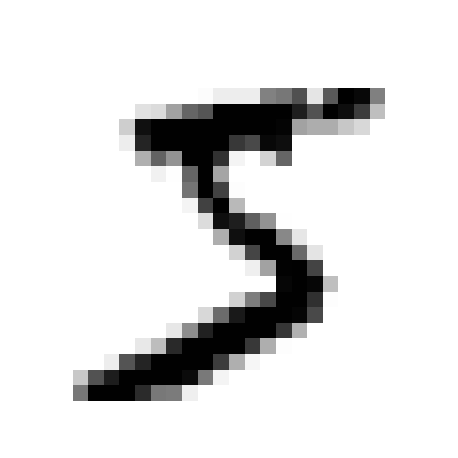

In [24]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary") #cmap="binary" means to get a grayscale color map where 0 is white and 255 is black
    plt.axis("off")
    
some_digit = X[0]
plot_digit(some_digit)
save_image("some_digit")
    

In [25]:
# above image seems like a 5
y[0]

'5'

In [26]:
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[:60000]

### Training a Binary Classifier